purpose: reimplement OpenBox method and extend it for CNN

In [1]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x

In [2]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

# CNN

In [3]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 320)
        x = self.classifier(x)
        return x

net = CNN()
x = to_var(torch.randn(28 * 28).view(1, 1, 28, 28))
net(x)

tensor([[ 0.1010, -0.1051, -0.1859, -0.0163, -0.0377, -0.1172,  0.0446, -0.0580,
          0.2632, -0.1981]], grad_fn=<ThAddmmBackward>)

In [49]:
net = nn.Conv2d(5, 2, kernel_size=2)
net.bias

Parameter containing:
tensor([0.0501, 0.0934], requires_grad=True)

In [50]:
x = to_var(torch.arange(9*5).view(1,5,3,3)).float()
net(x)

tensor([[[[24.1622, 24.4250],
          [24.9506, 25.2134]],

         [[20.5121, 21.3307],
          [22.9678, 23.7863]]]], grad_fn=<ThnnConv2DBackward>)

In [51]:
def fill_row_conv(W, x_nr, x_nc, offset):
    d = x_nr * x_nc
    nr, nc = W.shape
    res = torch.zeros(d)
    for r in range(nr):
        for c in range(nc):
            res[r * x_nc + c + offset] = W[r, c]
    return res

def conv_openbox(W, b, x):
    '''Current implementation is highly memory inefficient, use sparse matrix later
    note: currently doesn't handle stride
    
    W: convolution weight
    b: convolution bias
    '''
    assert len(x.shape) == 3, "assume no batch dimension"
    in_channels, x_nr, x_nc = x.shape
    d = x.numel()

    convW = []
    convB = torch.FloatTensor()

    for out_channel in range(W.shape[0]):
        rows = []
        for in_channel in range(W.shape[1]):
            block = []
            nr, nc = W[out_channel, in_channel].shape
            for r in range(x_nr - nr + 1):
                for c in range(x_nc - nc + 1):
                    offset = r * x_nc + c
                    lrow = fill_row_conv(W[out_channel, in_channel], x_nr, x_nc, offset)
                    block.append(lrow.unsqueeze(0))
            rows.append(torch.cat(block,0))
        rows = torch.cat(rows, 1) # hstack in np
        convB = torch.cat([convB, b[out_channel].repeat(len(rows))])
        convW.append(rows)

    convW = torch.cat(convW, 0) # vstack in np
    return convW, convB

convW, convB = conv_openbox(net.weight, net.bias, x[0])
print(torch.mv(convW, x[0].view(-1)) + convB)
print(net(x).view(-1))        


tensor([24.1622, 24.4250, 24.9506, 25.2134, 20.5121, 21.3307, 22.9678, 23.7863],
       grad_fn=<ThAddBackward>)
tensor([24.1622, 24.4250, 24.9506, 25.2134, 20.5121, 21.3307, 22.9678, 23.7863],
       grad_fn=<ViewBackward>)


In [72]:
net = nn.MaxPool2d(kernel_size=1)
net

MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)

In [73]:
x = to_var(torch.arange(16*5).view(1,5,4,4)).float()
net(x).shape

torch.Size([1, 5, 4, 4])

In [74]:
def fill_row_maxpool2d(x, ks, offset):
    n_channel, x_nr, x_nc = x.shape    
    row = to_var(torch.zeros(n_channel * x_nr * x_nc))
    vals = [(r, c, x.view(-1)[r * x_nc + c + offset]) for r in range(ks) for c in range(ks)]
    r, c, _ = max(vals, key=lambda x: x[2])
    row[r * x_nc + c + offset] = 1
    return row

def maxpool2d_openbox(l, x):
    '''note that current implementation is not memory efficient (use sparse instead)
    Also it assumes padding is 0
    l: the layer
    '''
    assert len(x.shape) == 3, "assume no batch dimension"
    ks = l.kernel_size
    stride = l.stride
    
    W = []
    b = 0
    
    n_channel, x_nr, x_nc = x.shape
    for in_channel in range(n_channel):
        for r in range(0, x_nr - ks + 1, stride):
            for c in range(0, x_nc - ks + 1, stride):
                offset = in_channel * (x_nc * x_nr) + r * x_nc + c
                row = fill_row_maxpool2d(x, ks, offset)
                W.append(row.unsqueeze(0))
    W = torch.cat(W, 0) # vstack in np
    return W, b

W, b = maxpool2d_openbox(net, x[0])
print(torch.mv(W, x[0].view(-1)) + b)
print(net(x).view(-1))        

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79.])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79.])


# the key is to construct sparse toeplitz matrix using scipy.sparse.diags to make a convolution ready

In [81]:
def open_box(model, x): 
    # forward pass to determine configuration
    # assume x is flat with no batch dimension
    assert len(x.shape) == 1 or len(x.shape) == 3, "assume no batch dimension in input"
    d = x.numel()
    C = []
    
    # get W and b
    W = to_var(torch.eye(d))
    b = to_var(torch.zeros(d))
    z = x

    for i, c in enumerate(model.feature):
        if type(c) == torch.nn.modules.Conv2d:
            convW, convB = conv_openbox(c.weight, c.bias, z)
            W = torch.mm(convW, W)
            b = convB + torch.mv(convW, b)
            z = c(z.unsqueeze(0))[0] # conv layer doesn't allow no batch
        elif type(c) == torch.nn.modules.ReLU:
            z_shape = z.shape
            z = z.view(-1)
            
            C.extend(list((z > 0).int().data.numpy())) # configuration
            r = (z > 0).float() # the slope
            t = torch.zeros_like(z) # the bias
            W = torch.mm(torch.diag(r), W)
            b = t + torch.mv(torch.diag(r), b)
            
            z = z.view(z_shape)
            z = c(z)
        elif type(c) == torch.nn.modules.LeakyReLU:
            z_shape = z.shape
            z = z.view(-1)
            
            C.extend(list((z > 0).int().data.numpy())) # configuration
            r = (z > 0).float() # the slope
            r[r==0] = c.negative_slope
            t = torch.zeros_like(z) # the bias
            W = torch.mm(torch.diag(r), W)
            b = t + torch.mv(torch.diag(r), b)  
            
            z = z.view(z_shape)
            z = c(z)
        elif type(c) == torch.nn.modules.MaxPool2d:
            maxW, maxb = maxpool2d_openbox(c, z)
            W = torch.mm(maxW, W)
            b = maxb + torch.mv(maxW, b)
            z = c(z)
        else:
            raise Exception('unknown layer')

    z = z.view(-1) # flatten input
    for i, c in enumerate(model.classifier):
        if type(c) == torch.nn.modules.linear.Linear:
            W = torch.mm(c.weight, W)
            b = c.bias + torch.mv(c.weight, b)
        elif type(c) == torch.nn.modules.ReLU:
            C.extend(list((z > 0).int().data.numpy())) # configuration
            r = (z > 0).float() # the slope
            t = torch.zeros_like(z) # the bias
            W = torch.mm(torch.diag(r), W)
            b = t + torch.mv(torch.diag(r), b)
        elif type(c) == torch.nn.modules.LeakyReLU:
            C.extend(list((z > 0).int().data.numpy())) # configuration
            r = (z > 0).float() # the slope
            r[r==0] = c.negative_slope
            t = torch.zeros_like(z) # the bias
            W = torch.mm(torch.diag(r), W)
            b = t + torch.mv(torch.diag(r), b)  
        else:
            raise Exception('unknown layer')
            
        z = c(z) # forward pass
    
    C = ''.join(map(str, C))
    return W, b, C


In [82]:
net = CNN()
x = to_var(torch.randn(28 * 28).view(1, 1, 28, 28))
net(x)

tensor([[ 0.0943,  0.0848, -0.2455,  0.0103,  0.0528,  0.0594, -0.1761, -0.0112,
         -0.1323,  0.2685]], grad_fn=<ThAddmmBackward>)

In [84]:
W, b, C = open_box(net, x[0])

In [86]:
net(x)

tensor([[ 0.0943,  0.0848, -0.2455,  0.0103,  0.0528,  0.0594, -0.1761, -0.0112,
         -0.1323,  0.2685]], grad_fn=<ThAddmmBackward>)

In [90]:
torch.mv(W, x.view(-1)) + b

tensor([ 0.0943,  0.0848, -0.2455,  0.0103,  0.0528,  0.0594, -0.1761, -0.0112,
        -0.1323,  0.2685], grad_fn=<ThAddBackward>)

100%|██████████| 10/10 [01:31<00:00,  9.12s/it]


checking if it is exact
min: 0.000000, mean: 0.000000, max: 0.000000


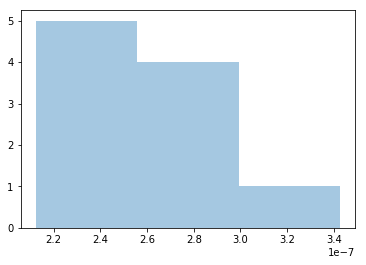

In [94]:
def abs_diff(a, b):
    return torch.abs(a - b).sum().data.numpy()

def diff_check_mnist(net, num_runs=100):
    diff = []
    for i in tqdm.tqdm(range(num_runs)):
        x = to_var(torch.randn(28 * 28).view(1, 1, 28, 28))
        W, b, C = open_box(net, x[0])
        diff.append(abs_diff(torch.mv(W, x.view(-1)) + b, net(x)))
    return diff

diff = diff_check_mnist(net, num_runs=10)
sns.distplot(diff, kde=False)
print('checking if it is exact')
print('min: %f, mean: %f, max: %f' % (np.min(diff), np.mean(diff), np.max(diff)))

CNN(
  (feature): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


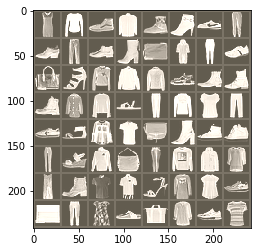

[1,   400] loss: 0.7429808899
[1,   800] loss: 0.4743512917
[2,   400] loss: 0.3913103890
[2,   800] loss: 0.3843482326
[3,   400] loss: 0.3498836927
[3,   800] loss: 0.3307087557
[4,   400] loss: 0.3088420809
[4,   800] loss: 0.3071981326
[5,   400] loss: 0.2864819093
[5,   800] loss: 0.2866851807
[6,   400] loss: 0.2710752106
[6,   800] loss: 0.2650511582
[7,   400] loss: 0.2557104905
[7,   800] loss: 0.2535451249
[8,   400] loss: 0.2434429568
[8,   800] loss: 0.2464966522
[9,   400] loss: 0.2341977183
[9,   800] loss: 0.2377072705
[10,   400] loss: 0.2182296025
Finished Training in 300s


In [96]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

net = CNN()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

x, y = next(iter(train_loader))
show_tensor_image(x)

train(net, train_loader, criterion, optimizer, print_every=400, epochs=10, max_time=300)

In [97]:
show_acc(net, test_loader)

Accuracy of the network on 10000  images: 90 %


In [98]:
def getAvgImg(loader, criteria=lambda x: True):
    res = 0
    count = 0
    for x, y in loader:
        for i, im in enumerate(x):
            if criteria(y[i]):
                count += 1
                res += im
    return (res / count).numpy().reshape(28,28)

avg_images = []
for i in tqdm.tqdm(range(10)):
    im = getAvgImg(train_loader, criteria=lambda y: y == i)
    avg_images.append(im)

100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


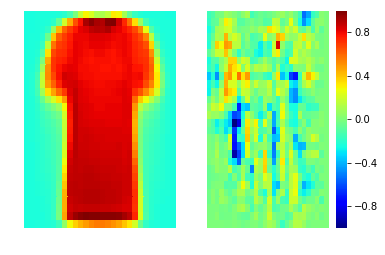

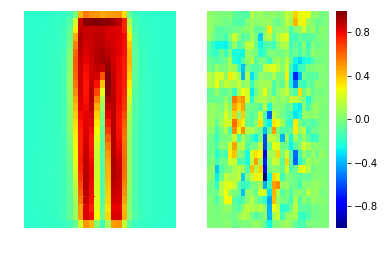

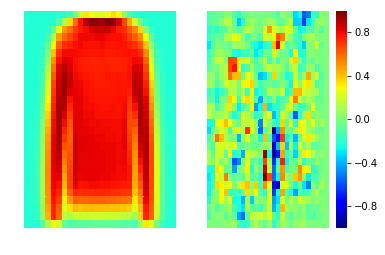

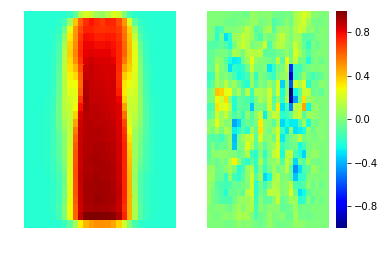

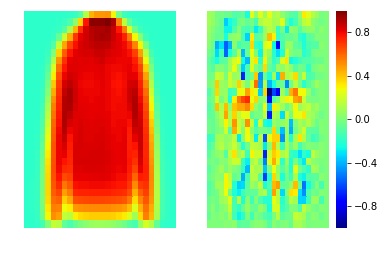

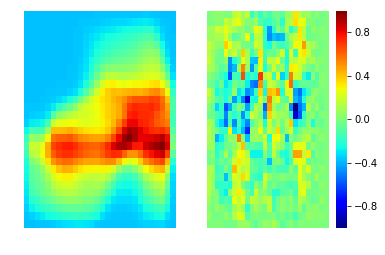

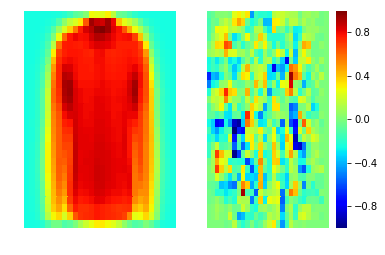

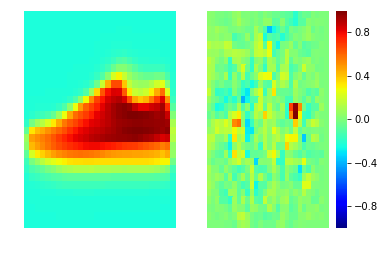

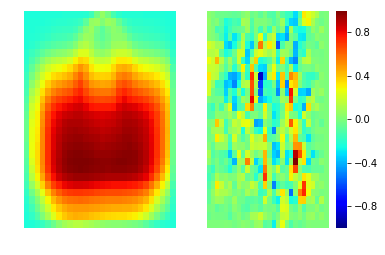

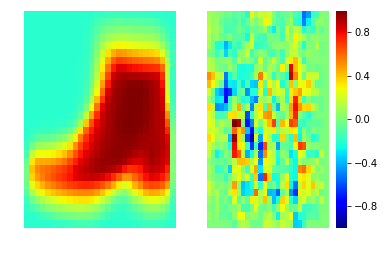

In [100]:
# visualization
def scale_figure(im): # scale activation to -1 to 1
    im = im / np.abs(im).max()
    return im

W, b, C = open_box(net, x[0])
for i in range(10):
    plt.subplot(121)
    im = scale_figure(avg_images[i])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(122)
    w = W[i] - W.mean(0)
    im = scale_figure(w.data.numpy().reshape(28,28))
    sns.heatmap(im, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')

    plt.show()



# Fashion MNIST Binary Case (Paper Replication)

Lesson learned: multiple class explanation is hard to learn (could be one of future direction), first focus on binary cases

60000it [00:09, 6427.28it/s]
10000it [00:01, 6782.47it/s]


tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])


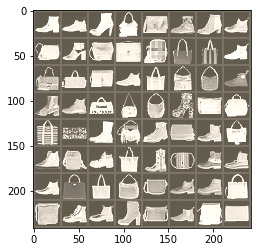

In [101]:
batch_size = 64

classes = [9, 8]

class SelectClasses():
    
    def __init__(self, classes):
        # remap classes labels
        self.classes = classes
    
    def __call__(self, y):
        num_classes = len(self.classes)
        try:
            return self.classes.index(y)
        except:
            return num_classes

train_data = datasets.FashionMNIST('fmnist_data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]),
                      target_transform=SelectClasses(classes)
                     )
test_data = datasets.FashionMNIST('fmnist_data', train=False, 
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ]),
                     target_transform=SelectClasses(classes)
                    )

train_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(train_data)):
    if y < len(classes):
        train_subset.append(i)

test_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(test_data)):
    if y < len(classes):
        test_subset.append(i)        
        
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_subset))

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_subset))

x, y = next(iter(train_loader))
print(y)
show_tensor_image(x)

In [103]:
fmnist1 = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fmnist1.parameters(), weight_decay=1e-4)
train(fmnist1, train_loader, criterion, optimizer, print_every=100, epochs=10, max_time=100)

[1,   100] loss: 0.1669251751
[2,   100] loss: 0.0116075986
[3,   100] loss: 0.0074806333
[4,   100] loss: 0.0072707756
[5,   100] loss: 0.0101906336
[6,   100] loss: 0.0041315963
[7,   100] loss: 0.0037822025
[8,   100] loss: 0.0024540511
[9,   100] loss: 0.0023105380
[10,   100] loss: 0.0021305756
Finished Training in 56s


In [104]:
show_acc(fmnist1, test_loader)

Accuracy of the network on 2000  images: 99 %


In [105]:
# run this cell only after speed up of openbox_conv
# config_counter_fmnist1 = count_config(fmnist1, train_loader)

In [106]:
# run this cell only after speed up of openbox_conv
'''
sorted_fmnist1_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), 
                                    config_counter_fmnist1.items()), 
                                key=lambda x: x[1], reverse=True)

plt.plot(list(map(lambda x: x[1], sorted_fmnist1_configs)), '+', label='total')
plt.plot(list(map(lambda x: x[2], sorted_fmnist1_configs)), '+', label='negative')
plt.plot(list(map(lambda x: x[3], sorted_fmnist1_configs)), '+', label='positive')

plt.title('number of instances in each llc of fmnist1')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')
plt.legend()
'''

"\nsorted_fmnist1_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), \n                                    config_counter_fmnist1.items()), \n                                key=lambda x: x[1], reverse=True)\n\nplt.plot(list(map(lambda x: x[1], sorted_fmnist1_configs)), '+', label='total')\nplt.plot(list(map(lambda x: x[2], sorted_fmnist1_configs)), '+', label='negative')\nplt.plot(list(map(lambda x: x[3], sorted_fmnist1_configs)), '+', label='positive')\n\nplt.title('number of instances in each llc of fmnist1')\nplt.xlabel('local linear classifiers')\nplt.ylabel('instances in training set')\nplt.legend()\n"

In [107]:
# run this cell only after speed up of openbox_conv
'''
top = 10
print('config %s has %d instances (%d positive, %d negative) ranks %d' % (sorted_fmnist1_configs[top][0], 
                                                                          sorted_fmnist1_configs[top][1], 
                                                                          sorted_fmnist1_configs[top][3],
                                                                          sorted_fmnist1_configs[top][2],
                                                                          top))
x = find_x(sorted_fmnist1_configs[top][0], fmnist1, train_loader)

W, b, C = open_box(fmnist1, x.view(784))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])

for i in range(2):
    plt.subplot(gs[0])
    im = scale_figure(avg_images[classes[i]])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(gs[1])
    j = 0 if i==1 else 1
    w = W[i] - W[j]
    im = scale_figure(w.data.numpy().reshape(28,28))
    cax = sns.heatmap(im, cmap='jet', vmin=-1, vmax=1, cbar=True)
    plt.gca().axis('off')
    
    plt.show()
'''

"\ntop = 10\nprint('config %s has %d instances (%d positive, %d negative) ranks %d' % (sorted_fmnist1_configs[top][0], \n                                                                          sorted_fmnist1_configs[top][1], \n                                                                          sorted_fmnist1_configs[top][3],\n                                                                          sorted_fmnist1_configs[top][2],\n                                                                          top))\nx = find_x(sorted_fmnist1_configs[top][0], fmnist1, train_loader)\n\nW, b, C = open_box(fmnist1, x.view(784))\ngs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])\n\nfor i in range(2):\n    plt.subplot(gs[0])\n    im = scale_figure(avg_images[classes[i]])\n    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)\n    plt.gca().axis('off')\n    \n    plt.subplot(gs[1])\n    j = 0 if i==1 else 1\n    w = W[i] - W[j]\n    im = scale_figure(w.data.numpy().reshape(28,28))\n 

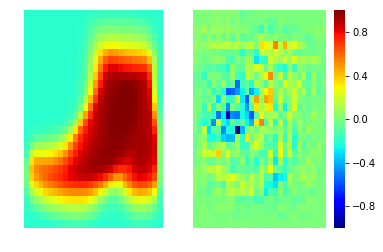

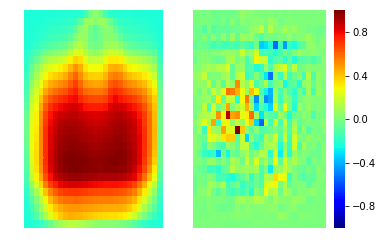

In [109]:
W, b, C = open_box(fmnist1, x[0])
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])

for i in range(2):
    plt.subplot(gs[0])
    im = scale_figure(avg_images[classes[i]])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(gs[1])
    j = 0 if i==1 else 1
    w = W[i] - W[j]
    im = scale_figure(w.data.numpy().reshape(28,28))
    cax = sns.heatmap(im, cmap='jet', vmin=-1, vmax=1, cbar=True)
    plt.gca().axis('off')
    
    plt.show()
